Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.8 MB/s 
     |████████████████████████████████| 120 kB 86.0 MB/s 
     |████████████████████████████████| 6.6 MB 72.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=c71468628079e163b73c09772337db080c3f0299f4ad0a7c55b40db42da7f4ee
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['B-LEGISLACAO', 'O', 'I-LEGISLACAO']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

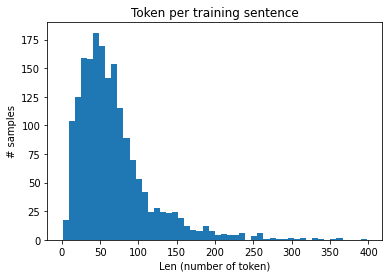

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

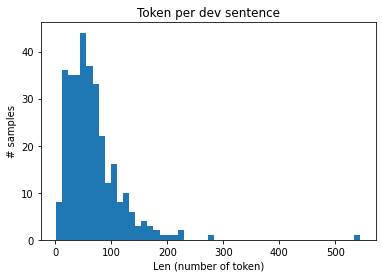

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

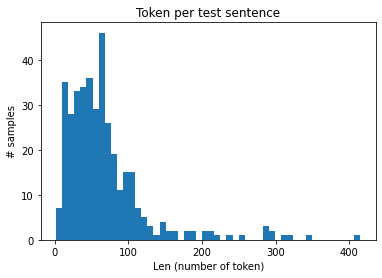

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

8577
663.133,14
0
B-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 908
Points in y_train before removal: 908


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[2201, 10868, 9306, 7508, 5505, 6989, 12838, 10215, 6989, 842, 8858, 8118, 7826, 7798, 7428, 9916, 12742, 4010, 2260, 11609, 6989, 8118, 13420, 8208, 4010, 11263, 2964, 6992, 587, 12395, 1605, 12780, 6989, 6787, 6123, 2912, 11102, 4010, 4730, 9250, 6198, 8685, 11703, 1338, 12391, 5408, 13226, 2067, 2964, 8572, 10703, 6989, 6901, 4010, 4437, 9035, 10372, 12063, 8118, 7212, 4010, 1565, 3668, 9250, 12622, 5408, 12731, 10868]
[1, 1, 1, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[978, 8357, 6989, 4354, 2912, 8727, 8706, 2964, 3652, 9916, 559, 4718, 5053, 13372, 6658, 9916, 10019, 9916, 6971, 3092, 6989, 5415, 487, 1395, 3764, 5230, 8318, 6141, 12701, 9916, 10813, 339, 13388, 13302, 6901, 13420, 5014, 2275, 9916, 10445, 5138, 8318, 3246, 6989, 8318, 10815, 6989, 13232, 8348, 8318, 3935, 10142, 10427, 364, 9250, 2214, 2709, 12391, 7508, 6881, 

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.0 MB/s 
     |████████████████████████████████| 6.6 MB 61.9 MB/s 
     |████████████████████████████████| 120 kB 48.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=9dc653cb178a962c7c674d07e54bf55a2de8c7ab91cd4abf92915c53e7631d0d
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[2201, 10868, 9306, 7508, 5505, 6989, 12838, 10215, 6989, 

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1286494731903076
Training loss epoch: 0.13007854452977577
Training accuracy epoch: 0.9550594593308004
Validating model...
Validation Loss: 0.02413979246436308
Validation Accuracy: 0.9925607239918179
Training epoch: 2
Training loss per 100 training steps: 0.011581647209823132
Training loss epoch: 0.018553960905001873
Training accuracy epoch: 0.9946380919565418
Validating model...
Validation Loss: 0.018034650484055635
Validation Accuracy: 0.994527844586761
Training epoch: 3
Training loss per 100 training steps: 0.014506547711789608
Training loss epoch: 0.010395498691012332
Training accuracy epoch: 0.996888768121182
Validating model...
Validation Loss: 0.02870583763745214
Validation Accuracy: 0.9917546509073022
Training epoch: 4
Training loss per 100 training steps: 0.010617269203066826
Training loss epoch: 0.008515047632451905
Training accuracy epoch: 0.9976037012927613
Validating model...
Validation Loss: 0.014382062678036857
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015555374566853667
Validation Accuracy: 0.9959398573667987
Validation duration: 0.08114636666666683 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.97      0.97      1238

   micro avg       0.97      0.97      0.97      1238
   macro avg       0.97      0.97      0.97      1238
weighted avg       0.97      0.97      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1039127111434937
Training loss epoch: 0.13345783386836974
Training accuracy epoch: 0.9550607829555184
Validating model...
Training epoch: 2
Training loss per 100 training steps: 0.029451925307512283
Training loss epoch: 0.0200786522442573
Training accuracy epoch: 0.9942222904504415
Validating model...
Validation Loss: 0.015451360638031647
Validation Accuracy: 0.995477887873098
Training epoch: 3
Training loss per 100 training steps: 0.01650126650929451
Training loss epoch: 0.01058662523262268
Training accuracy epoch: 0.9967978975247808
Validating model...
Validation Loss: 0.01641316016113186
Validation Accuracy: 0.9954441442612525
Training epoch: 4
Training loss per 100 training steps: 0.0038872347213327885
Training loss epoch: 0.005940356230559318
Training accuracy epoch: 0.9983765370043459
Validating model...
Validation Loss: 0.019732167254828493
Validation Accuracy: 0.9956697198030382
Training epoch: 5
Training loss per 100 tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01955114621766067
Validation Accuracy: 0.9955638076460039
Validation duration: 0.0794131666666658 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0930445194244385
Training loss epoch: 0.1189053248156581
Training accuracy epoch: 0.9595159859054033
Validating model...
Validation Loss: 0.025939405696200474
Validation Accuracy: 0.9919480205765225
Training epoch: 2
Training loss per 100 training steps: 0.025690218433737755
Training loss epoch: 0.01992654586374237
Training accuracy epoch: 0.9940965987596392
Validating model...
Validation Loss: 0.014509347131631026
Validation Accuracy: 0.9958547913840692
Training epoch: 3
Training loss per 100 training steps: 0.02093741111457348
Training loss epoch: 0.01098864695073612
Training accuracy epoch: 0.9966232172288354
Validating model...
Validation Loss: 0.020980098362391193
Validation Accuracy: 0.9948228134604468
Training epoch: 4
Training loss per 100 training steps: 0.0017264613416045904
Training loss epoch: 0.009566502055365658
Training accuracy epoch: 0.9971816981439754
Validating model...
Validation Loss: 0.015350123818193208
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01686106550975334
Validation Accuracy: 0.9958339685438214
Validation duration: 0.08133589999999913 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9970605373382568
Training loss epoch: 0.115160085424258
Training accuracy epoch: 0.962757080298851
Validating model...
Validation Loss: 0.025013038245517583
Validation Accuracy: 0.9920884206237724
Training epoch: 2
Training loss per 100 training steps: 0.03196272999048233
Training loss epoch: 0.01943629210520732
Training accuracy epoch: 0.9942434166123892
Validating model...
Validation Loss: 0.015029152251026105
Validation Accuracy: 0.995248394878865
Training epoch: 3
Training loss per 100 training steps: 0.006329911295324564
Training loss epoch: 0.011639326072518566
Training accuracy epoch: 0.996564283828188
Validating model...
Validation Loss: 0.01564574981707015
Validation Accuracy: 0.9955953622161735
Training epoch: 4
Training loss per 100 training steps: 0.009935799054801464
Training loss epoch: 0.013865493256353625
Training accuracy epoch: 0.9958372711672577
Validating model...
Validation Loss: 0.013110164767741003
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015871530398726463
Validation Accuracy: 0.9957853310407544
Validation duration: 0.08028373333333244 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1221697330474854
Training loss epoch: 0.1262189273052571
Training accuracy epoch: 0.9565163549871947
Validating model...
Validation Loss: 0.025431209914608018
Validation Accuracy: 0.9922601205238056
Training epoch: 2
Training loss per 100 training steps: 0.013382871635258198
Training loss epoch: 0.020573302784836607
Training accuracy epoch: 0.9939209204381131
Validating model...
Validation Loss: 0.02700220292345399
Validation Accuracy: 0.9931078286236511
Training epoch: 3
Training loss per 100 training steps: 0.01324727013707161
Training loss epoch: 0.011061787872836647
Training accuracy epoch: 0.9967152583194493
Validating model...
Validation Loss: 0.01942914583127103
Validation Accuracy: 0.9950175219578395
Training epoch: 4
Training loss per 100 training steps: 0.007684208452701569
Training loss epoch: 0.0092104500131028
Training accuracy epoch: 0.9972775246746641
Validating model...
Validation Loss: 0.019327329187944997
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02052090687357122
Validation Accuracy: 0.995737696195358
Validation duration: 0.0808548499999991 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2835267782211304
Training loss epoch: 0.1286082347495514
Training accuracy epoch: 0.9537751470809354
Validating model...
Validation Loss: 0.02358808210175041
Validation Accuracy: 0.9932163488185429
Training epoch: 2
Training loss per 100 training steps: 0.008403436280786991
Training loss epoch: 0.020285145191704494
Training accuracy epoch: 0.9939954925570119
Validating model...
Validation Loss: 0.022104150105622552
Validation Accuracy: 0.9940871679137551
Training epoch: 3
Training loss per 100 training steps: 0.011350690387189388
Training loss epoch: 0.010376389689841553
Training accuracy epoch: 0.9967975446265621
Validating model...
Validation Loss: 0.012917687176100333
Validation Accuracy: 0.9966207321866735
Training epoch: 4
Training loss per 100 training steps: 0.005119194742292166
Training loss epoch: 0.007997514176582754
Training accuracy epoch: 0.9978387458144439
Validating model...
Validation Loss: 0.015656507738250575
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016254638457515586
Validation Accuracy: 0.9957519644726459
Validation duration: 0.07917939999999817 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3166733980178833
Training loss epoch: 0.1374799454127226
Training accuracy epoch: 0.9515418021095899
Validating model...
Validation Loss: 0.0249551201926633
Validation Accuracy: 0.9930533165958385
Training epoch: 2
Training loss per 100 training steps: 0.0219860952347517
Training loss epoch: 0.020058914806628435
Training accuracy epoch: 0.9942886261841191
Validating model...
Validation Loss: 0.0212218752574353
Validation Accuracy: 0.9944365302863342
Training epoch: 3
Training loss per 100 training steps: 0.0060449508018791676
Training loss epoch: 0.014573012719649756
Training accuracy epoch: 0.9954773052461384
Validating model...
Validation Loss: 0.01947442473222812
Validation Accuracy: 0.9936778654181857
Training epoch: 4
Training loss per 100 training steps: 0.009153974242508411
Training loss epoch: 0.01119111903755223
Training accuracy epoch: 0.9963334601543016
Validating model...
Validation Loss: 0.01711573492779973
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012711297182249837
Validation Accuracy: 0.9965090469716332
Validation duration: 0.08079220000000381 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0326590538024902
Training loss epoch: 0.12467407704772134
Training accuracy epoch: 0.9554719335711767
Validating model...
Validation Loss: 0.022896965433444296
Validation Accuracy: 0.9926657880928919
Training epoch: 2
Training loss per 100 training steps: 0.0039062178693711758
Training loss epoch: 0.018243555575935988
Training accuracy epoch: 0.994992444863993
Validating model...
Validation Loss: 0.017363525672061814
Validation Accuracy: 0.9949455910400082
Training epoch: 3
Training loss per 100 training steps: 0.002495150314643979
Training loss epoch: 0.010837612183470475
Training accuracy epoch: 0.9968631713796097
Validating model...
Validation Loss: 0.01833212487482732
Validation Accuracy: 0.9952846265033725
Training epoch: 4
Training loss per 100 training steps: 0.00603622617200017
Training loss epoch: 0.009886130571095763
Training accuracy epoch: 0.9970657714626829
Validating model...
Validation Loss: 0.018772045717923902
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020194980810629204
Validation Accuracy: 0.9946226390165469
Validation duration: 0.07913323333333058 minutes
F1-score (test): 95.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9485149383544922
Training loss epoch: 0.10740400192311458
Training accuracy epoch: 0.9658702504137993
Validating model...
Validation Loss: 0.025992314375582196
Validation Accuracy: 0.992925957587105
Training epoch: 2
Training loss per 100 training steps: 0.015189524739980698
Training loss epoch: 0.020948367977612896
Training accuracy epoch: 0.9935554949674903
Validating model...
Validation Loss: 0.020421462832018733
Validation Accuracy: 0.9935929320239405
Training epoch: 3
Training loss per 100 training steps: 0.004050843883305788
Training loss epoch: 0.010420314773606757
Training accuracy epoch: 0.9967971024207328
Validating model...
Validation Loss: 0.015514018738204391
Validation Accuracy: 0.9960905486618851
Training epoch: 4
Training loss per 100 training steps: 0.016472069546580315
Training loss epoch: 0.008913419975310956
Training accuracy epoch: 0.9977086408623425
Validating model...
Validation Loss: 0.013791627283873302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016320456529986888
Validation Accuracy: 0.9964583539657549
Validation duration: 0.08067746666667214 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 908
Points in y_train after augmentation: 908
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2192682027816772
Training loss epoch: 0.13735597551261125
Training accuracy epoch: 0.9529280590614104
Validating model...
Validation Loss: 0.036845813549700235
Validation Accuracy: 0.9879810673187589
Training epoch: 2
Training loss per 100 training steps: 0.03973143920302391
Training loss epoch: 0.021414322427294234
Training accuracy epoch: 0.9936989919925427
Validating model...
Validation Loss: 0.021216717720519574
Validation Accuracy: 0.9944797631081861
Training epoch: 3
Training loss per 100 training steps: 0.00914426613599062
Training loss epoch: 0.012571301736068307
Training accuracy epoch: 0.9959709160567207
Validating model...
Validation Loss: 0.015793704728518303
Validation Accuracy: 0.9955560312312587
Training epoch: 4
Training loss per 100 training steps: 0.0015340415993705392
Training loss epoch: 0.006477138770972951
Training accuracy epoch: 0.9979095318722416
Validating model...
Validation Loss: 0.014167609179691811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017004163705375202
Validation Accuracy: 0.9950251994824392
Validation duration: 0.0815154833333357 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.15401029586792
Training loss epoch: 0.10446091618021609
Training accuracy epoch: 0.9621768453537267
Validating model...
Validation Loss: 0.02186465374792793
Validation Accuracy: 0.9929808514945422
Training epoch: 2
Training loss per 100 training steps: 0.021234294399619102
Training loss epoch: 0.021717833853523497
Training accuracy epoch: 0.9939854484176956
Validating model...
Validation Loss: 0.018227645484287115
Validation Accuracy: 0.9950710605521603
Training epoch: 3
Training loss per 100 training steps: 0.014209034852683544
Training loss epoch: 0.011322025563830222
Training accuracy epoch: 0.9966590723613563
Validating model...
Validation Loss: 0.014744852226050128
Validation Accuracy: 0.995870181969711
Training epoch: 4
Training loss per 100 training steps: 0.0037235463969409466
Training loss epoch: 0.007085096739514561
Training accuracy epoch: 0.9979598344269216
Validating model...
Validation Loss: 0.017246569231030576
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018777762224393275
Validation Accuracy: 0.9948234373786781
Validation duration: 0.08017423333333226 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1995110511779785
Training loss epoch: 0.11928022460041332
Training accuracy epoch: 0.9588118012033491
Validating model...
Validation Loss: 0.022744572022929788
Validation Accuracy: 0.9931689692251553
Training epoch: 2
Training loss per 100 training steps: 0.032218072563409805
Training loss epoch: 0.020850836817489962
Training accuracy epoch: 0.9933627628225211
Validating model...
Validation Loss: 0.018101700659220416
Validation Accuracy: 0.9941533888166143
Training epoch: 3
Training loss per 100 training steps: 0.00997723825275898
Training loss epoch: 0.01207193407938409
Training accuracy epoch: 0.9964309267789844
Validating model...
Validation Loss: 0.019482201985305266
Validation Accuracy: 0.9940732184284777
Training epoch: 4
Training loss per 100 training steps: 0.006272327154874802
Training loss epoch: 0.006766287809152576
Training accuracy epoch: 0.99789073660137
Validating model...
Validation Loss: 0.017072566011587957
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018673664215687797
Validation Accuracy: 0.9954006568072155
Validation duration: 0.0795761999999892 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0420751571655273
Training loss epoch: 0.11319632085801011
Training accuracy epoch: 0.962459421687755
Validating model...
Validation Loss: 0.023351619812837315
Validation Accuracy: 0.993000757412146
Training epoch: 2
Training loss per 100 training steps: 0.007158468011766672
Training loss epoch: 0.021967499575931842
Training accuracy epoch: 0.9936501295222433
Validating model...
Validation Loss: 0.013044102538731835
Validation Accuracy: 0.9963098856776879
Training epoch: 3
Training loss per 100 training steps: 0.005506375338882208
Training loss epoch: 0.011090646771727209
Training accuracy epoch: 0.9964325824391423
Validating model...
Validation Loss: 0.01517105349644442
Validation Accuracy: 0.9963137153428412
Training epoch: 4
Training loss per 100 training steps: 0.001703721354715526
Training loss epoch: 0.008459321916772341
Training accuracy epoch: 0.9975213933930299
Validating model...
Validation Loss: 0.016707371129000205
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019902110056136735
Validation Accuracy: 0.9946199874993548
Validation duration: 0.07894994999999956 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.049527645111084
Training loss epoch: 0.10420681224663703
Training accuracy epoch: 0.9656376712904473
Validating model...
Validation Loss: 0.027053999875317373
Validation Accuracy: 0.9912075046875741
Training epoch: 2
Training loss per 100 training steps: 0.032783202826976776
Training loss epoch: 0.022649532075787723
Training accuracy epoch: 0.9932472943757464
Validating model...
Validation Loss: 0.018039161680332785
Validation Accuracy: 0.9949838359846226
Training epoch: 3
Training loss per 100 training steps: 0.008561478927731514
Training loss epoch: 0.011141596343958567
Training accuracy epoch: 0.9969374755462638
Validating model...
Validation Loss: 0.01834970736221987
Validation Accuracy: 0.9943111773333013
Training epoch: 4
Training loss per 100 training steps: 0.005672407802194357
Training loss epoch: 0.00866989329995089
Training accuracy epoch: 0.9974175001869225
Validating model...
Validation Loss: 0.022984226709619787
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01806435422137535
Validation Accuracy: 0.995675235068191
Validation duration: 0.08075706666666822 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.161207675933838
Training loss epoch: 0.11289341488695691
Training accuracy epoch: 0.9603822099898033
Validating model...
Validation Loss: 0.02626969143083053
Validation Accuracy: 0.9928892830222764
Training epoch: 2
Training loss per 100 training steps: 0.036440253257751465
Training loss epoch: 0.02043570344283862
Training accuracy epoch: 0.9942582750192835
Validating model...
Validation Loss: 0.018089130387774537
Validation Accuracy: 0.9953456097568654
Training epoch: 3
Training loss per 100 training steps: 0.012785893864929676
Training loss epoch: 0.014438949236777467
Training accuracy epoch: 0.9955384832185974
Validating model...
Validation Loss: 0.016320818150970376
Validation Accuracy: 0.9960500403657223
Training epoch: 4
Training loss per 100 training steps: 0.01987280137836933
Training loss epoch: 0.009252084220733337
Training accuracy epoch: 0.997320654896069
Validating model...
Validation Loss: 0.0168753909646988
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.025470736266773503
Validation Accuracy: 0.9936590187331412
Validation duration: 0.08116645000000063 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9512565732002258
Training loss epoch: 0.12145490864370491
Training accuracy epoch: 0.9607777958322385
Validating model...
Validation Loss: 0.024021702804713555
Validation Accuracy: 0.9920775409000959
Training epoch: 2
Training loss per 100 training steps: 0.024124626070261
Training loss epoch: 0.02334422871313045
Training accuracy epoch: 0.993381169112184
Validating model...
Validation Loss: 0.015926115785814113
Validation Accuracy: 0.9954527035298384
Training epoch: 3
Training loss per 100 training steps: 0.0069060842506587505
Training loss epoch: 0.012429883346145212
Training accuracy epoch: 0.996418086286749
Validating model...
Validation Loss: 0.023772370535880327
Validation Accuracy: 0.9944662423452095
Training epoch: 4
Training loss per 100 training steps: 0.002669732319191098
Training loss epoch: 0.007862602381042244
Training accuracy epoch: 0.9976288932696631
Validating model...
Validation Loss: 0.016090703154207273
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01858132891356945
Validation Accuracy: 0.9941984224189365
Validation duration: 0.07869715000000117 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.96      1238

   micro avg       0.94      0.97      0.96      1238
   macro avg       0.94      0.97      0.96      1238
weighted avg       0.94      0.97      0.96      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9908947944641113
Training loss epoch: 0.12032341505859939
Training accuracy epoch: 0.9595913161471483
Validating model...
Validation Loss: 0.023106070689945704
Validation Accuracy: 0.9924374075049262
Training epoch: 2
Training loss per 100 training steps: 0.04499863088130951
Training loss epoch: 0.022425511137018322
Training accuracy epoch: 0.9930544565797355
Validating model...
Validation Loss: 0.030329235718541202
Validation Accuracy: 0.9891160698810753
Training epoch: 3
Training loss per 100 training steps: 0.012037476524710655
Training loss epoch: 0.012878003540042211
Training accuracy epoch: 0.9961192747682602
Validating model...
Validation Loss: 0.01793475950225478
Validation Accuracy: 0.9941464210930709
Training epoch: 4
Training loss per 100 training steps: 0.013509834185242653
Training loss epoch: 0.0090713675779907
Training accuracy epoch: 0.9971062694605871
Validating model...
Validation Loss: 0.014979290654688763
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017474643151217606
Validation Accuracy: 0.9957066909377214
Validation duration: 0.08061431666666673 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1610199213027954
Training loss epoch: 0.12646817809469263
Training accuracy epoch: 0.957406721267513
Validating model...
Validation Loss: 0.022745499775434535
Validation Accuracy: 0.9924980672880137
Training epoch: 2
Training loss per 100 training steps: 0.015575655736029148
Training loss epoch: 0.022274195865898485
Training accuracy epoch: 0.9934520342426101
Validating model...
Validation Loss: 0.04114291967735404
Validation Accuracy: 0.98940700761597
Training epoch: 3
Training loss per 100 training steps: 0.030493246391415596
Training loss epoch: 0.015016298855877888
Training accuracy epoch: 0.9957834314827788
Validating model...
Validation Loss: 0.017222482481017886
Validation Accuracy: 0.9958689660822532
Training epoch: 4
Training loss per 100 training steps: 0.0034489145036786795
Training loss epoch: 0.009084500346175382
Training accuracy epoch: 0.9973954783247381
Validating model...
Validation Loss: 0.0188201211345759
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018342638685377704
Validation Accuracy: 0.9963505372502052
Validation duration: 0.07877223333333253 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2709206342697144
Training loss epoch: 0.12149326659371736
Training accuracy epoch: 0.9562089844499068
Validating model...
Validation Loss: 0.023555781160082136
Validation Accuracy: 0.9926543798211389
Training epoch: 2
Training loss per 100 training steps: 0.023743517696857452
Training loss epoch: 0.023039651687034
Training accuracy epoch: 0.9937182546922314
Validating model...
Validation Loss: 0.019577794924511442
Validation Accuracy: 0.9945157820087367
Training epoch: 3
Training loss per 100 training steps: 0.012552324682474136
Training loss epoch: 0.01385765168717472
Training accuracy epoch: 0.9958595832779532
Validating model...
Validation Loss: 0.028822128045638756
Validation Accuracy: 0.9914017207350615
Training epoch: 4
Training loss per 100 training steps: 0.020039187744259834
Training loss epoch: 0.013593977537747262
Training accuracy epoch: 0.9958152906362329
Validating model...
Validation Loss: 0.017848436899449944
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019961526823559932
Validation Accuracy: 0.9953916744001644
Validation duration: 0.07885915000000145 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1135
Points in y_train after augmentation: 1135
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1283271312713623
Training loss epoch: 0.10895535251466741
Training accuracy epoch: 0.9614973673655766
Validating model...
Validation Loss: 0.023439685769733928
Validation Accuracy: 0.9927146547816412
Training epoch: 2
Training loss per 100 training steps: 0.026579808443784714
Training loss epoch: 0.02454238142949385
Training accuracy epoch: 0.9928412425471288
Validating model...
Validation Loss: 0.017031327824086128
Validation Accuracy: 0.9949158957825043
Training epoch: 3
Training loss per 100 training steps: 0.020152172073721886
Training loss epoch: 0.013374174999164969
Training accuracy epoch: 0.9961682748734386
Validating model...
Validation Loss: 0.015601393364791181
Validation Accuracy: 0.9949410811714243
Training epoch: 4
Training loss per 100 training steps: 0.020256616175174713
Training loss epoch: 0.007472467067254655
Training accuracy epoch: 0.997761850768215
Validating model...
Validation Loss: 0.01743531906478373
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0183162600757593
Validation Accuracy: 0.9949616401115002
Validation duration: 0.07890319999999823 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238



In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0526912212371826
Training loss epoch: 0.11197630204476935
Training accuracy epoch: 0.9623764561364808
Validating model...
Validation Loss: 0.023868538516884048
Validation Accuracy: 0.9920016607657798
Training epoch: 2
Training loss per 100 training steps: 0.015946384519338608
Training loss epoch: 0.02084410351668593
Training accuracy epoch: 0.9943171255233814
Validating model...
Validation Loss: 0.015434187581940066
Validation Accuracy: 0.9955240525880581
Training epoch: 3
Training loss per 100 training steps: 0.005564150400459766
Training loss epoch: 0.015097316725417798
Training accuracy epoch: 0.9954250110140168
Validating model...
Validation Loss: 0.01750695632238473
Validation Accuracy: 0.9946508339780622
Training epoch: 4
Training loss per 100 training steps: 0.006925057154148817
Training loss epoch: 0.01088842402718593
Training accuracy epoch: 0.9966251629762108
Validating model...
Validation Loss: 0.01626255459822936
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020946036354871467
Validation Accuracy: 0.9936953542855279
Validation duration: 0.07876981666666628 minutes
F1-score (test): 95.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.98      0.96      1238

   micro avg       0.93      0.98      0.96      1238
   macro avg       0.93      0.98      0.96      1238
weighted avg       0.93      0.98      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1687885522842407
Training loss epoch: 0.0999002186798079
Training accuracy epoch: 0.96490264048713
Validating model...
Validation Loss: 0.024273106096578494
Validation Accuracy: 0.9921089333154381
Training epoch: 2
Training loss per 100 training steps: 0.05750863999128342
Training loss epoch: 0.02186892841141238
Training accuracy epoch: 0.9938324117647137
Validating model...
Validation Loss: 0.030330611969388667
Validation Accuracy: 0.9874457380815181
Training epoch: 3
Training loss per 100 training steps: 0.01979992911219597
Training loss epoch: 0.016964651152172106
Training accuracy epoch: 0.9946950071361416
Validating model...
Validation Loss: 0.011912025755182618
Validation Accuracy: 0.9964813178450475
Training epoch: 4
Training loss per 100 training steps: 0.011308965273201466
Training loss epoch: 0.009401731045515992
Training accuracy epoch: 0.99729963424734
Validating model...
Validation Loss: 0.018386258857346894
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016636963964022772
Validation Accuracy: 0.9956566703095405
Validation duration: 0.07875293333333198 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1422855854034424
Training loss epoch: 0.11574575043998139
Training accuracy epoch: 0.9598517923335311
Validating model...
Validation Loss: 0.02749431007985203
Validation Accuracy: 0.991454542728689
Training epoch: 2
Training loss per 100 training steps: 0.020317019894719124
Training loss epoch: 0.022686903132125735
Training accuracy epoch: 0.9932313081771351
Validating model...
Validation Loss: 0.015595667194464199
Validation Accuracy: 0.9951646487619286
Training epoch: 3
Training loss per 100 training steps: 0.00685102166607976
Training loss epoch: 0.012223525862155353
Training accuracy epoch: 0.9966419670055005
Validating model...
Validation Loss: 0.015020007503889723
Validation Accuracy: 0.9950946939530806
Training epoch: 4
Training loss per 100 training steps: 0.0013178035151213408
Training loss epoch: 0.007317252610783028
Training accuracy epoch: 0.9977613139114464
Validating model...
Validation Loss: 0.037203077997435774
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01689798014558619
Validation Accuracy: 0.9960030301280415
Validation duration: 0.07899144999998195 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9739744663238525
Training loss epoch: 0.09308217835157763
Training accuracy epoch: 0.9702659053188784
Validating model...
Validation Loss: 0.020149237199109934
Validation Accuracy: 0.9935123696758301
Training epoch: 2
Training loss per 100 training steps: 0.009776853956282139
Training loss epoch: 0.01998648043386205
Training accuracy epoch: 0.9941460723533845
Validating model...
Validation Loss: 0.01743921363127551
Validation Accuracy: 0.9944975369761663
Training epoch: 3
Training loss per 100 training steps: 0.018835678696632385
Training loss epoch: 0.012278308823899648
Training accuracy epoch: 0.9964066400328174
Validating model...
Validation Loss: 0.01897866574013495
Validation Accuracy: 0.9953195853653936
Training epoch: 4
Training loss per 100 training steps: 0.0043638586066663265
Training loss epoch: 0.0094671382116652
Training accuracy epoch: 0.9971016961546716
Validating model...
Validation Loss: 0.014193462365212673
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017061070382624166
Validation Accuracy: 0.9952374685286434
Validation duration: 0.07926431666667971 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.114436388015747
Training loss epoch: 0.09946395635474907
Training accuracy epoch: 0.9660094522209174
Validating model...
Validation Loss: 0.026818355234960716
Validation Accuracy: 0.992328910186969
Training epoch: 2
Training loss per 100 training steps: 0.014276796951889992
Training loss epoch: 0.02354193303928992
Training accuracy epoch: 0.9931903845778537
Validating model...
Validation Loss: 0.01666870805257488
Validation Accuracy: 0.995124778635069
Training epoch: 3
Training loss per 100 training steps: 0.021298319101333618
Training loss epoch: 0.013602117387859453
Training accuracy epoch: 0.995981216779346
Validating model...
Validation Loss: 0.02507447075497891
Validation Accuracy: 0.9929336546238684
Training epoch: 4
Training loss per 100 training steps: 0.004119163379073143
Training loss epoch: 0.009193963001666288
Training accuracy epoch: 0.9973955680205676
Validating model...
Validation Loss: 0.021392980637583173
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019288814190076664
Validation Accuracy: 0.9944905272365792
Validation duration: 0.0808316500000122 minutes
F1-score (test): 95.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2110575437545776
Training loss epoch: 0.10307725050573259
Training accuracy epoch: 0.9653798854180028
Validating model...
Validation Loss: 0.022434492872673132
Validation Accuracy: 0.9937373472407252
Training epoch: 2
Training loss per 100 training steps: 0.024879340082406998
Training loss epoch: 0.018227084715807335
Training accuracy epoch: 0.994818183449553
Validating model...
Validation Loss: 0.016322918197450537
Validation Accuracy: 0.9956223427564138
Training epoch: 3
Training loss per 100 training steps: 0.015518685802817345
Training loss epoch: 0.010559642606219926
Training accuracy epoch: 0.9968209449810685
Validating model...
Validation Loss: 0.016129566335058326
Validation Accuracy: 0.9955023803418639
Training epoch: 4
Training loss per 100 training steps: 0.005760107655078173
Training loss epoch: 0.0077678072838204765
Training accuracy epoch: 0.9976130895462428
Validating model...
Validation Loss: 0.017951910372219226

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01628168434156881
Validation Accuracy: 0.9958218605314704
Validation duration: 0.08112501666667717 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9567462801933289
Training loss epoch: 0.0954029263581994
Training accuracy epoch: 0.9691418923673315
Validating model...
Validation Loss: 0.01895857862074904
Validation Accuracy: 0.9941973676921333
Training epoch: 2
Training loss per 100 training steps: 0.0056592924520373344
Training loss epoch: 0.0198699532666915
Training accuracy epoch: 0.9940960891999804
Validating model...
Validation Loss: 0.019837527696619787
Validation Accuracy: 0.9944454424343651
Training epoch: 3
Training loss per 100 training steps: 0.03219887986779213
Training loss epoch: 0.010749298158686521
Training accuracy epoch: 0.9967637944551434
Validating model...
Validation Loss: 0.013283090629903157
Validation Accuracy: 0.9961745239333859
Training epoch: 4
Training loss per 100 training steps: 0.006864884868264198
Training loss epoch: 0.008884276676960939
Training accuracy epoch: 0.997244431627598
Validating model...
Validation Loss: 0.017569805096302713
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016534112767355207
Validation Accuracy: 0.9952450215821037
Validation duration: 0.07887756666665761 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0179367065429688
Training loss epoch: 0.09456269940642943
Training accuracy epoch: 0.9692756001841193
Validating model...
Validation Loss: 0.021462502368238
Validation Accuracy: 0.993557746864887
Training epoch: 2
Training loss per 100 training steps: 0.05412106588482857
Training loss epoch: 0.02197636402859136
Training accuracy epoch: 0.9932261563679738
Validating model...
Validation Loss: 0.062158015567720645
Validation Accuracy: 0.9861126273867765
Training epoch: 3
Training loss per 100 training steps: 0.0021934679243713617
Training loss epoch: 0.012535025154478675
Training accuracy epoch: 0.9961200774352285
Validating model...
Validation Loss: 0.018193331724476246
Validation Accuracy: 0.9955486315955029
Training epoch: 4
Training loss per 100 training steps: 0.016528721898794174
Training loss epoch: 0.014235833425583794
Training accuracy epoch: 0.9958797969737326
Validating model...
Validation Loss: 0.019185078420421286
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02315526067832252
Validation Accuracy: 0.9947210383285038
Validation duration: 0.0807619833333168 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.195686936378479
Training loss epoch: 0.10130876081800738
Training accuracy epoch: 0.9649912322656796
Validating model...
Validation Loss: 0.022277369191648348
Validation Accuracy: 0.9929677712518397
Training epoch: 2
Training loss per 100 training steps: 0.016046952456235886
Training loss epoch: 0.02217289716611768
Training accuracy epoch: 0.9938233002367117
Validating model...
Validation Loss: 0.02514330221761373
Validation Accuracy: 0.9928430246925612
Training epoch: 3
Training loss per 100 training steps: 0.029057208448648453
Training loss epoch: 0.014950983698728906
Training accuracy epoch: 0.9956699500360944
Validating model...
Validation Loss: 0.027123982100636653
Validation Accuracy: 0.993233793865539
Training epoch: 4
Training loss per 100 training steps: 0.010880649089813232
Training loss epoch: 0.009067520165889048
Training accuracy epoch: 0.99742299247477
Validating model...
Validation Loss: 0.016304563098293284
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018514435122294042
Validation Accuracy: 0.9945479454972318
Validation duration: 0.08025903333330765 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1362
Points in y_train after augmentation: 1362
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1410590410232544
Training loss epoch: 0.09929920752467804
Training accuracy epoch: 0.9656308664378297
Validating model...
Validation Loss: 0.022276889133666242
Validation Accuracy: 0.9926321531828425
Training epoch: 2
Training loss per 100 training steps: 0.010100830346345901
Training loss epoch: 0.02106122847451547
Training accuracy epoch: 0.9935135024534226
Validating model...
Validation Loss: 0.019208369477252876
Validation Accuracy: 0.9937374657448907
Training epoch: 3
Training loss per 100 training steps: 0.010369081981480122
Training loss epoch: 0.014627031550125414
Training accuracy epoch: 0.9958103951087944
Validating model...
Validation Loss: 0.019361376627265208
Validation Accuracy: 0.99471576840193
Training epoch: 4
Training loss per 100 training steps: 0.010847723111510277
Training loss epoch: 0.010641417433616034
Training accuracy epoch: 0.9966334318635203
Validating model...
Validation Loss: 0.014285865541231553
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01972302769111896
Validation Accuracy: 0.9955576704845027
Validation duration: 0.08096340000001874 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238



In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0891685485839844
Training loss epoch: 0.09708393996115774
Training accuracy epoch: 0.966834208573435
Validating model...
Validation Loss: 0.02107021089510194
Validation Accuracy: 0.993648744117015
Training epoch: 2
Training loss per 100 training steps: 0.021914822980761528
Training loss epoch: 0.019215031806379557
Training accuracy epoch: 0.9940789802377918
Validating model...
Validation Loss: 0.033095600438259896
Validation Accuracy: 0.9915942036018783
Training epoch: 3
Training loss per 100 training steps: 0.0018059152644127607
Training loss epoch: 0.015381864020600915
Training accuracy epoch: 0.9954735670071553
Validating model...
Validation Loss: 0.020997123440749766
Validation Accuracy: 0.9935946383557211
Training epoch: 4
Training loss per 100 training steps: 0.018088780343532562
Training loss epoch: 0.008906244681566023
Training accuracy epoch: 0.997445516034164
Validating model...
Validation Loss: 0.019344994097038926
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020865429990711466
Validation Accuracy: 0.99501371196149
Validation duration: 0.07910481666664661 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.23576819896698
Training loss epoch: 0.09956520554609596
Training accuracy epoch: 0.9658276558674155
Validating model...
Validation Loss: 0.021456096551403226
Validation Accuracy: 0.9932158437674212
Training epoch: 2
Training loss per 100 training steps: 0.019017763435840607
Training loss epoch: 0.01799998360918835
Training accuracy epoch: 0.9950317341279247
Validating model...
Validation Loss: 0.020259195534024565
Validation Accuracy: 0.9936406769119912
Training epoch: 3
Training loss per 100 training steps: 0.010282031260430813
Training loss epoch: 0.011558987729949876
Training accuracy epoch: 0.9965403068573103
Validating model...
Validation Loss: 0.01729185338176432
Validation Accuracy: 0.9952138610581708
Training epoch: 4
Training loss per 100 training steps: 0.0029794168658554554
Training loss epoch: 0.011100586883549113
Training accuracy epoch: 0.9964987121586344
Validating model...
Validation Loss: 0.016121975711679885
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017523749820005225
Validation Accuracy: 0.9953582698669562
Validation duration: 0.08050566666667389 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1884067058563232
Training loss epoch: 0.09600619888864458
Training accuracy epoch: 0.9666818031759273
Validating model...
Validation Loss: 0.027112727718693868
Validation Accuracy: 0.9922592441285258
Training epoch: 2
Training loss per 100 training steps: 0.026651937514543533
Training loss epoch: 0.021466195003595204
Training accuracy epoch: 0.9935541145661634
Validating model...
Validation Loss: 0.021163571343225027
Validation Accuracy: 0.9928556089584162
Training epoch: 3
Training loss per 100 training steps: 0.022481227293610573
Training loss epoch: 0.012053547113901004
Training accuracy epoch: 0.9964739309448568
Validating model...
Validation Loss: 0.024399302373196752
Validation Accuracy: 0.9928501194209345
Training epoch: 4
Training loss per 100 training steps: 0.008020801469683647
Training loss epoch: 0.007047328604676295
Training accuracy epoch: 0.9978704791717697
Validating model...
Validation Loss: 0.018918154572713234

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.025211033978848718
Validation Accuracy: 0.9949421542601263
Validation duration: 0.08093803333334411 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1462219953536987
Training loss epoch: 0.08450855456292629
Training accuracy epoch: 0.9706466690191619
Validating model...
Validation Loss: 0.02054166300444021
Validation Accuracy: 0.9947799026696716
Training epoch: 2
Training loss per 100 training steps: 0.018044209107756615
Training loss epoch: 0.017309305910021066
Training accuracy epoch: 0.9950955641630783
Validating model...
Validation Loss: 0.016992492789757393
Validation Accuracy: 0.9953907076413406
Training epoch: 3
Training loss per 100 training steps: 0.01650557667016983
Training loss epoch: 0.012947252740850672
Training accuracy epoch: 0.9961381676559327
Validating model...
Validation Loss: 0.024214427302857593
Validation Accuracy: 0.9928998479343472
Training epoch: 4
Training loss per 100 training steps: 0.015397117473185062
Training loss epoch: 0.0075426059396704655
Training accuracy epoch: 0.997591253812057
Validating model...
Validation Loss: 0.0204749157086813
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01779824357314889
Validation Accuracy: 0.9948418400233213
Validation duration: 0.08092416666668215 minutes
F1-score (test): 95.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9906774163246155
Training loss epoch: 0.08624117261730134
Training accuracy epoch: 0.9721628558064765
Validating model...
Validation Loss: 0.022164022860427696
Validation Accuracy: 0.9931438032479699
Training epoch: 2
Training loss per 100 training steps: 0.04035608097910881
Training loss epoch: 0.020322848834330217
Training accuracy epoch: 0.9943601963675002
Validating model...
Validation Loss: 0.017056688344815656
Validation Accuracy: 0.994595243453265
Training epoch: 3
Training loss per 100 training steps: 0.009890427812933922
Training loss epoch: 0.013787744181463495
Training accuracy epoch: 0.995707002468496
Validating model...
Validation Loss: 0.021377640521331204
Validation Accuracy: 0.9938300355306989
Training epoch: 4
Training loss per 100 training steps: 0.006923472508788109
Training loss epoch: 0.007542738541087601
Training accuracy epoch: 0.9978827707197641
Validating model...
Validation Loss: 0.019185679306420275
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021888117693985503
Validation Accuracy: 0.9938818418112637
Validation duration: 0.07876640000001013 minutes
F1-score (test): 95.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.96      1238

   micro avg       0.94      0.97      0.96      1238
   macro avg       0.94      0.97      0.96      1238
weighted avg       0.94      0.97      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9469134211540222
Training loss epoch: 0.09377815008629113
Training accuracy epoch: 0.9707082904081616
Validating model...
Validation Loss: 0.025453297410249
Validation Accuracy: 0.9930662753965669
Training epoch: 2
Training loss per 100 training steps: 0.02209632471203804
Training loss epoch: 0.01912475927500054
Training accuracy epoch: 0.9944242552455188
Validating model...
Validation Loss: 0.01811635800515346
Validation Accuracy: 0.9948049292551419
Training epoch: 3
Training loss per 100 training steps: 0.013888807967305183
Training loss epoch: 0.011427829889580608
Training accuracy epoch: 0.996685599157966
Validating model...
Validation Loss: 0.01721291683844313
Validation Accuracy: 0.9956354847843847
Training epoch: 4
Training loss per 100 training steps: 0.004551407415419817
Training loss epoch: 0.007139574602479115
Training accuracy epoch: 0.9979019403507802
Validating model...
Validation Loss: 0.017086153866590133
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0237546190910507
Validation Accuracy: 0.9946301381310946
Validation duration: 0.07888638333333801 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3094629049301147
Training loss epoch: 0.09278429583180696
Training accuracy epoch: 0.9673231435290838
Validating model...
Validation Loss: 0.021453668718181905
Validation Accuracy: 0.9932041173302328
Training epoch: 2
Training loss per 100 training steps: 0.009359674528241158
Training loss epoch: 0.01851431395742111
Training accuracy epoch: 0.9947845855743236
Validating model...
Validation Loss: 0.011896248019876935
Validation Accuracy: 0.9962198729801398
Training epoch: 3
Training loss per 100 training steps: 0.016408560797572136
Training loss epoch: 0.010730320580187254
Training accuracy epoch: 0.9970527718755886
Validating model...
Validation Loss: 0.01699718127271072
Validation Accuracy: 0.9953456921513129
Training epoch: 4
Training loss per 100 training steps: 0.002610706491395831
Training loss epoch: 0.012052261413773522
Training accuracy epoch: 0.9965143037369739
Validating model...
Validation Loss: 0.01933565509638616
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018353860708884895
Validation Accuracy: 0.9943439474474757
Validation duration: 0.07863868333333812 minutes
F1-score (test): 95.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1829713582992554
Training loss epoch: 0.0969890322163701
Training accuracy epoch: 0.9666475872180571
Validating model...
Validation Loss: 0.021770149070237364
Validation Accuracy: 0.9932728431201603
Training epoch: 2
Training loss per 100 training steps: 0.019005125388503075
Training loss epoch: 0.01934910102048889
Training accuracy epoch: 0.9942322001204762
Validating model...
Validation Loss: 0.015370134740979188
Validation Accuracy: 0.995000524191183
Training epoch: 3
Training loss per 100 training steps: 0.0023129270412027836
Training loss epoch: 0.01229065774474293
Training accuracy epoch: 0.9962038848643244
Validating model...
Validation Loss: 0.016696226252298357
Validation Accuracy: 0.99513401944478
Training epoch: 4
Training loss per 100 training steps: 0.009338581003248692
Training loss epoch: 0.008149237833567895
Training accuracy epoch: 0.9975671763417765
Validating model...
Validation Loss: 0.02595636915759228
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016274423115343477
Validation Accuracy: 0.9947887803513679
Validation duration: 0.07854933333334581 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.98      0.96      1238

   micro avg       0.93      0.98      0.96      1238
   macro avg       0.93      0.98      0.96      1238
weighted avg       0.93      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8738738298416138
Training loss epoch: 0.0893911845330149
Training accuracy epoch: 0.9730922907307622
Validating model...
Validation Loss: 0.01946277081567262
Validation Accuracy: 0.9942444041181746
Training epoch: 2
Training loss per 100 training steps: 0.004589228890836239
Training loss epoch: 0.019548414670862258
Training accuracy epoch: 0.9942047121828935
Validating model...
Validation Loss: 0.018762647357237126
Validation Accuracy: 0.9945707192919657
Training epoch: 3
Training loss per 100 training steps: 0.013884691521525383
Training loss epoch: 0.010002004792913794
Training accuracy epoch: 0.9967823393756474
Validating model...
Validation Loss: 0.01676978768331797
Validation Accuracy: 0.9959814758830537
Training epoch: 4
Training loss per 100 training steps: 0.0035154481884092093
Training loss epoch: 0.009273396888747811
Training accuracy epoch: 0.9971123821929381
Validating model...
Validation Loss: 0.02030117785657889
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.027487521458776126
Validation Accuracy: 0.9944965478329162
Validation duration: 0.07923168333333402 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1589
Points in y_train after augmentation: 1589
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9928996562957764
Training loss epoch: 0.08676239820197225
Training accuracy epoch: 0.9712592003130267
Validating model...
Validation Loss: 0.022957233567943887
Validation Accuracy: 0.9923370343551325
Training epoch: 2
Training loss per 100 training steps: 0.052765049040317535
Training loss epoch: 0.019722333040554076
Training accuracy epoch: 0.9942316901968584
Validating model...
Validation Loss: 0.015044716519436665
Validation Accuracy: 0.9948639902412252
Training epoch: 3
Training loss per 100 training steps: 0.013999171555042267
Training loss epoch: 0.010656258301460185
Training accuracy epoch: 0.9967045379904519
Validating model...
Validation Loss: 0.01726641345469813
Validation Accuracy: 0.994781502360812
Training epoch: 4
Training loss per 100 training steps: 0.013164721429347992
Training loss epoch: 0.007523275603307411
Training accuracy epoch: 0.9975435391146196
Validating model...
Validation Loss: 0.021370724930464
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02081215736689046
Validation Accuracy: 0.9946044804899286
Validation duration: 0.07928223333334851 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238



In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3296352624893188
Training loss per 100 training steps: 0.10217154819038834
Training loss epoch: 0.09422157698294573
Training accuracy epoch: 0.9676148615495778
Validating model...
Validation Loss: 0.019960774632636458
Validation Accuracy: 0.9932216818863088
Training epoch: 2
Training loss per 100 training steps: 0.017109517008066177
Training loss per 100 training steps: 0.019588793922990264
Training loss epoch: 0.01950875358459981
Training accuracy epoch: 0.993986466770819
Validating model...
Validation Loss: 0.016872893514422078
Validation Accuracy: 0.9950353116789563
Training epoch: 3
Training loss per 100 training steps: 0.00676427548751235
Training loss per 100 training steps: 0.009468415806226727
Training loss epoch: 0.00990067637247736
Training accuracy epoch: 0.9971809120395286
Validating model...
Validation Loss: 0.017523282052328188
Validation Accuracy: 0.9957366968522304
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021413419914703507
Validation Accuracy: 0.9949616393758193
Validation duration: 0.07926358333334065 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9366357922554016
Training loss per 100 training steps: 0.08463413729378493
Training loss epoch: 0.07817081705944841
Training accuracy epoch: 0.9751361695490819
Validating model...
Validation Loss: 0.026925837399349326
Validation Accuracy: 0.9909726612170441
Training epoch: 2
Training loss per 100 training steps: 0.022809050977230072
Training loss per 100 training steps: 0.016420800079785212
Training loss epoch: 0.01572176015408906
Training accuracy epoch: 0.9953603620765991
Validating model...
Validation Loss: 0.04206989368512517
Validation Accuracy: 0.988261215865356
Training epoch: 3
Training loss per 100 training steps: 0.013112511485815048
Training loss per 100 training steps: 0.009120594020840703
Training loss epoch: 0.00931952205658155
Training accuracy epoch: 0.9973080701750565
Validating model...
Validation Loss: 0.018068157104564653
Validation Accuracy: 0.9948272982153487
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018418166180102464
Validation Accuracy: 0.9955210173037202
Validation duration: 0.07836618333337052 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1444951295852661
Training loss per 100 training steps: 0.09754493102283761
Training loss epoch: 0.08989798621552293
Training accuracy epoch: 0.9697329551379054
Validating model...
Validation Loss: 0.025546771252439135
Validation Accuracy: 0.991674747320672
Training epoch: 2
Training loss per 100 training steps: 0.033062439411878586
Training loss per 100 training steps: 0.019539917812286183
Training loss epoch: 0.019511604661187322
Training accuracy epoch: 0.9941790489438522
Validating model...
Validation Loss: 0.015384268558894595
Validation Accuracy: 0.9951788549072331
Training epoch: 3
Training loss per 100 training steps: 0.0303715281188488
Training loss per 100 training steps: 0.011332668619931187
Training loss epoch: 0.011015390824085395
Training accuracy epoch: 0.9968540456627135
Validating model...
Validation Loss: 0.020252364695936973
Validation Accuracy: 0.9948125962689722
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018730707039746147
Validation Accuracy: 0.9949280133889374
Validation duration: 0.07893208333328706 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.96      1238

   micro avg       0.96      0.97      0.96      1238
   macro avg       0.96      0.97      0.96      1238
weighted avg       0.96      0.97      0.96      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.088152289390564
Training loss per 100 training steps: 0.08676191407375701
Training loss epoch: 0.07990338281613954
Training accuracy epoch: 0.9739056616209163
Validating model...
Validation Loss: 0.022353449315276174
Validation Accuracy: 0.9935012282803344
Training epoch: 2
Training loss per 100 training steps: 0.01413998007774353
Training loss per 100 training steps: 0.016645391563894135
Training loss epoch: 0.016125724585563467
Training accuracy epoch: 0.9952472976791272
Validating model...
Validation Loss: 0.022559287652949848
Validation Accuracy: 0.9940540041112256
Training epoch: 3
Training loss per 100 training steps: 0.021165447309613228
Training loss per 100 training steps: 0.009274446647522031
Training loss epoch: 0.00995276191602706
Training accuracy epoch: 0.9970624085170899
Validating model...
Validation Loss: 0.02357082575049606
Validation Accuracy: 0.9931884020088398
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019268491048327025
Validation Accuracy: 0.9953541013703724
Validation duration: 0.07930544999999256 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.10031259059906
Training loss per 100 training steps: 0.08996617505419077
Training loss epoch: 0.083229824124525
Training accuracy epoch: 0.972538445644105
Validating model...
Validation Loss: 0.021860576334542463
Validation Accuracy: 0.9932595189767642
Training epoch: 2
Training loss per 100 training steps: 0.020945202559232712
Training loss per 100 training steps: 0.024236493817724213
Training loss epoch: 0.022903696235612427
Training accuracy epoch: 0.9934005133621956
Validating model...
Validation Loss: 0.04393387024867393
Validation Accuracy: 0.9887131333405131
Training epoch: 3
Training loss per 100 training steps: 0.015036716125905514
Training loss per 100 training steps: 0.010541774927278851
Training loss epoch: 0.01109345392283183
Training accuracy epoch: 0.9966853639530602
Validating model...
Validation Loss: 0.015271048895166521
Validation Accuracy: 0.995305617527121
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019937649931913864
Validation Accuracy: 0.9941976223230592
Validation duration: 0.07857074999998682 minutes
F1-score (test): 95.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.96      1238

   micro avg       0.94      0.97      0.96      1238
   macro avg       0.94      0.97      0.96      1238
weighted avg       0.94      0.97      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1699836254119873
Training loss per 100 training steps: 0.09990886659684158
Training loss epoch: 0.09201448281671394
Training accuracy epoch: 0.9692340511818613
Validating model...
Validation Loss: 0.033450697792605275
Validation Accuracy: 0.9904480140155718
Training epoch: 2
Training loss per 100 training steps: 0.02425975725054741
Training loss per 100 training steps: 0.017793903675963087
Training loss epoch: 0.017409930843042962
Training accuracy epoch: 0.9947735213031084
Validating model...
Validation Loss: 0.02449881839787676
Validation Accuracy: 0.9917383360706341
Training epoch: 3
Training loss per 100 training steps: 0.013545333407819271
Training loss per 100 training steps: 0.011262239951128602
Training loss epoch: 0.010796676457781965
Training accuracy epoch: 0.996891600917995
Validating model...
Validation Loss: 0.021736520756218982
Validation Accuracy: 0.9939069362382988
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020315037172016066
Validation Accuracy: 0.995279119366506
Validation duration: 0.07862966666665064 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2579618692398071
Training loss per 100 training steps: 0.10892438423810619
Training loss epoch: 0.10027415189369206
Training accuracy epoch: 0.9656395493910424
Validating model...
Validation Loss: 0.022428106172897276
Validation Accuracy: 0.9933513832171418
Training epoch: 2
Training loss per 100 training steps: 0.03198358416557312
Training loss per 100 training steps: 0.017160249879758914
Training loss epoch: 0.017280127216955612
Training accuracy epoch: 0.9951250687206129
Validating model...
Validation Loss: 0.027932636572846344
Validation Accuracy: 0.991353804452672
Training epoch: 3
Training loss per 100 training steps: 0.010819419287145138
Training loss per 100 training steps: 0.011523068394963767
Training loss epoch: 0.011241483749217239
Training accuracy epoch: 0.9966819808742899
Validating model...
Validation Loss: 0.014967191175119729
Validation Accuracy: 0.9957505894434323
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02242098146477171
Validation Accuracy: 0.9945255153129073
Validation duration: 0.0788752499999949 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.018139123916626
Training loss per 100 training steps: 0.08267241076446406
Training loss epoch: 0.07675246315959253
Training accuracy epoch: 0.9750512082755354
Validating model...
Validation Loss: 0.027591863053939528
Validation Accuracy: 0.9927171605034689
Training epoch: 2
Training loss per 100 training steps: 0.017169147729873657
Training loss per 100 training steps: 0.019029500267219425
Training loss epoch: 0.018937321290937496
Training accuracy epoch: 0.9947105824797776
Validating model...
Validation Loss: 0.034316697995001005
Validation Accuracy: 0.9866751400219304
Training epoch: 3
Training loss per 100 training steps: 0.010653345845639706
Training loss per 100 training steps: 0.00993615769006607
Training loss epoch: 0.010316546044410452
Training accuracy epoch: 0.9969484901554819
Validating model...
Validation Loss: 0.02546493258393769
Validation Accuracy: 0.9906540171049352
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.022355732556510095
Validation Accuracy: 0.9950382659770773
Validation duration: 0.07883381666670175 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.427286148071289
Training loss per 100 training steps: 0.11274079790357316
Training loss epoch: 0.1030445051167095
Training accuracy epoch: 0.9637375541865107
Validating model...
Validation Loss: 0.02675417287086713
Validation Accuracy: 0.9936924995249508
Training epoch: 2
Training loss per 100 training steps: 0.011694942601025105
Training loss per 100 training steps: 0.01889305614110193
Training loss epoch: 0.018299434985557014
Training accuracy epoch: 0.9946142493831457
Validating model...
Validation Loss: 0.02356462149016027
Validation Accuracy: 0.9928718263654417
Training epoch: 3
Training loss per 100 training steps: 0.0057543497532606125
Training loss per 100 training steps: 0.009155953496044483
Training loss epoch: 0.00946843998941691
Training accuracy epoch: 0.9970806756368722
Validating model...
Validation Loss: 0.020467161065122735
Validation Accuracy: 0.9948280235002106
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02767098067245873
Validation Accuracy: 0.9946256575131764
Validation duration: 0.08085943333335308 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1816
Points in y_train after augmentation: 1816
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1367144584655762
Training loss per 100 training steps: 0.09015197852294486
Training loss epoch: 0.08318280494820915
Training accuracy epoch: 0.9720376652019859
Validating model...
Validation Loss: 0.021034171760437034
Validation Accuracy: 0.9937730062270757
Training epoch: 2
Training loss per 100 training steps: 0.02680596522986889
Training loss per 100 training steps: 0.018571520286455454
Training loss epoch: 0.018074602074512655
Training accuracy epoch: 0.9947449355054625
Validating model...
Validation Loss: 0.015841722441282832
Validation Accuracy: 0.9953223565528578
Training epoch: 3
Training loss per 100 training steps: 0.004428120329976082
Training loss per 100 training steps: 0.010727553169063228
Training loss epoch: 0.010619484398232185
Training accuracy epoch: 0.9967487569938901
Validating model...
Validation Loss: 0.014301099885155313
Validation Accuracy: 0.9957667502251497
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0190327810778399
Validation Accuracy: 0.9947452081682001
Validation duration: 0.07926581666664181 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238



In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9228203892707825
Training loss per 100 training steps: 0.08631362579762936
Training loss epoch: 0.060600622887287445
Training accuracy epoch: 0.9814002812172222
Validating model...
Validation Loss: 0.02606546551743079
Validation Accuracy: 0.9895254511611271
Training epoch: 2
Training loss per 100 training steps: 0.01720542646944523
Training loss per 100 training steps: 0.01182445364146687
Training loss epoch: 0.011586726650633788
Training accuracy epoch: 0.9967032764506488
Validating model...
Validation Loss: 0.027066650545401943
Validation Accuracy: 0.9935566941408137
Training epoch: 3
Training loss per 100 training steps: 0.006335618440061808
Training loss per 100 training steps: 0.007918625677553108
Training loss epoch: 0.008704564953154791
Training accuracy epoch: 0.997533126341931
Validating model...
Validation Loss: 0.020256441707412403
Validation Accuracy: 0.9949985537719195
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02083378838627444
Validation Accuracy: 0.9944085749843784
Validation duration: 0.07891293333335246 minutes
F1-score (test): 95.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.98      0.96      1238

   micro avg       0.93      0.98      0.96      1238
   macro avg       0.93      0.98      0.96      1238
weighted avg       0.93      0.98      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0128191709518433
Training loss per 100 training steps: 0.09135029553481848
Training loss epoch: 0.0645471849146555
Training accuracy epoch: 0.9793771921403333
Validating model...
Validation Loss: 0.021561273839324713
Validation Accuracy: 0.9940730840424465
Training epoch: 2
Training loss per 100 training steps: 0.00601981719955802
Training loss per 100 training steps: 0.016644760048809912
Training loss epoch: 0.015251930411605502
Training accuracy epoch: 0.995659039544134
Validating model...
Validation Loss: 0.024412514178991495
Validation Accuracy: 0.9928436245359704
Training epoch: 3
Training loss per 100 training steps: 0.014048798941075802
Training loss per 100 training steps: 0.010671985230759008
Training loss epoch: 0.01001148143400607
Training accuracy epoch: 0.9970843394756631
Validating model...
Validation Loss: 0.0165312535606236
Validation Accuracy: 0.9958775065553063
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02013790737449502
Validation Accuracy: 0.9953609900588827
Validation duration: 0.07838578333333619 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.96      1238

   micro avg       0.96      0.97      0.96      1238
   macro avg       0.96      0.97      0.96      1238
weighted avg       0.96      0.97      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0165555477142334
Training loss per 100 training steps: 0.1017106124338242
Training loss epoch: 0.07130339981890038
Training accuracy epoch: 0.9779418417066228
Validating model...
Validation Loss: 0.018926307836192705
Validation Accuracy: 0.9939518044006688
Training epoch: 2
Training loss per 100 training steps: 0.023141929879784584
Training loss per 100 training steps: 0.015917059213918918
Training loss epoch: 0.015600343181735329
Training accuracy epoch: 0.9955954845465823
Validating model...
Validation Loss: 0.02027670203131579
Validation Accuracy: 0.9933810300663479
Training epoch: 3
Training loss per 100 training steps: 0.02669898420572281
Training loss per 100 training steps: 0.009428327010441941
Training loss epoch: 0.008788478030153953
Training accuracy epoch: 0.9972367715326631
Validating model...
Validation Loss: 0.0251460487156042
Validation Accuracy: 0.9938359601447657
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02643203944777876
Validation Accuracy: 0.9949851837207171
Validation duration: 0.07886664999999388 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0082587003707886
Training loss per 100 training steps: 0.09129554669990546
Training loss epoch: 0.0641993169866132
Training accuracy epoch: 0.9795955978393988
Validating model...
Validation Loss: 0.021616649084968402
Validation Accuracy: 0.993587695522597
Training epoch: 2
Training loss per 100 training steps: 0.014273708686232567
Training loss per 100 training steps: 0.013628633921080739
Training loss epoch: 0.013431203751743101
Training accuracy epoch: 0.9960483923407439
Validating model...
Validation Loss: 0.024336399978935896
Validation Accuracy: 0.9935613974295783
Training epoch: 3
Training loss per 100 training steps: 0.0011589797213673592
Training loss per 100 training steps: 0.008830865467022551
Training loss epoch: 0.00791862714448154
Training accuracy epoch: 0.9977616420863462
Validating model...
Validation Loss: 0.020767585093077894
Validation Accuracy: 0.9949005324749627
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02296127787652343
Validation Accuracy: 0.995947157201584
Validation duration: 0.0788194833333667 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2795146703720093
Training loss per 100 training steps: 0.10167899517582195
Training loss epoch: 0.07068953428918506
Training accuracy epoch: 0.976191340005678
Validating model...
Validation Loss: 0.02241294300516269
Validation Accuracy: 0.9942941978601122
Training epoch: 2
Training loss per 100 training steps: 0.0057265195064246655
Training loss per 100 training steps: 0.013797839916781476
Training loss epoch: 0.01355446595630516
Training accuracy epoch: 0.9962475969533556
Validating model...
Validation Loss: 0.023552772245325503
Validation Accuracy: 0.9922731380260975
Training epoch: 3
Training loss per 100 training steps: 0.0019930596463382244
Training loss per 100 training steps: 0.009351819597465899
Training loss epoch: 0.008668712655842108
Training accuracy epoch: 0.997448968989373
Validating model...
Validation Loss: 0.019550293099157335
Validation Accuracy: 0.9946625549308346
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.023904033538807806
Validation Accuracy: 0.994670227782304
Validation duration: 0.07855431666666846 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1984753608703613
Training loss per 100 training steps: 0.09101670358495989
Training loss epoch: 0.06279464822523949
Training accuracy epoch: 0.978598924072115
Validating model...
Validation Loss: 0.029600650249492554
Validation Accuracy: 0.9900220806435227
Training epoch: 2
Training loss per 100 training steps: 0.011197727173566818
Training loss per 100 training steps: 0.015204499125259348
Training loss epoch: 0.01493933608371503
Training accuracy epoch: 0.995816666576632
Validating model...
Validation Loss: 0.017497599201132766
Validation Accuracy: 0.9948193334537665
Training epoch: 3
Training loss per 100 training steps: 0.017529984936118126
Training loss per 100 training steps: 0.008073891063525093
Training loss epoch: 0.0074933990199603576
Training accuracy epoch: 0.9979087271557644
Validating model...
Validation Loss: 0.06658628465430368
Validation Accuracy: 0.9868471164099928
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02043373163905926
Validation Accuracy: 0.9943877619633668
Validation duration: 0.07827683333337822 minutes
F1-score (test): 95.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3285022974014282
Training loss per 100 training steps: 0.1092986401705311
Training loss epoch: 0.07460096488810247
Training accuracy epoch: 0.9738840484433662
Validating model...
Validation Loss: 0.019086321194966633
Validation Accuracy: 0.994357254459159
Training epoch: 2
Training loss per 100 training steps: 0.0081715639680624
Training loss per 100 training steps: 0.021625189579755878
Training loss epoch: 0.018997355279164137
Training accuracy epoch: 0.9944846502239079
Validating model...
Validation Loss: 0.016586187026751714
Validation Accuracy: 0.995411613528878
Training epoch: 3
Training loss per 100 training steps: 0.007280838210135698
Training loss per 100 training steps: 0.010279124059211832
Training loss epoch: 0.009699623684578558
Training accuracy epoch: 0.9972142959782149
Validating model...
Validation Loss: 0.03280991592466654
Validation Accuracy: 0.9929800186565553
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021253808930244606
Validation Accuracy: 0.9951080637818448
Validation duration: 0.07869863333338192 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0844895839691162
Training loss per 100 training steps: 0.09534355103600733
Training loss epoch: 0.06555080005479705
Training accuracy epoch: 0.9780364900807355
Validating model...
Validation Loss: 0.028348651576033307
Validation Accuracy: 0.9920907694951363
Training epoch: 2
Training loss per 100 training steps: 0.026821140199899673
Training loss per 100 training steps: 0.01770038912672144
Training loss epoch: 0.015670210469584934
Training accuracy epoch: 0.9957800945763422
Validating model...
Validation Loss: 0.01875820444686161
Validation Accuracy: 0.994837205830146
Training epoch: 3
Training loss per 100 training steps: 0.0009530961397103965
Training loss per 100 training steps: 0.008785596797715338
Training loss epoch: 0.008714605451797064
Training accuracy epoch: 0.9975865949166384
Validating model...
Validation Loss: 0.01750626746520755
Validation Accuracy: 0.995355386283215
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02117111491194616
Validation Accuracy: 0.9945742079009099
Validation duration: 0.08103243333334831 minutes
F1-score (test): 96.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8987849354743958
Training loss per 100 training steps: 0.09205493686886707
Training loss epoch: 0.06384484729408259
Training accuracy epoch: 0.9806252745915837
Validating model...
Validation Loss: 0.019064045045524836
Validation Accuracy: 0.9944623255659477
Training epoch: 2
Training loss per 100 training steps: 0.027009744197130203
Training loss per 100 training steps: 0.01623879859943201
Training loss epoch: 0.015105451507580995
Training accuracy epoch: 0.995601105671982
Validating model...
Validation Loss: 0.032183255634403655
Validation Accuracy: 0.9933615606453314
Training epoch: 3
Training loss per 100 training steps: 0.003991727251559496
Training loss per 100 training steps: 0.00846546183001379
Training loss epoch: 0.008021696403449706
Training accuracy epoch: 0.9975810510410263
Validating model...
Validation Loss: 0.021534797422992552
Validation Accuracy: 0.9947771635102615
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020805471227504313
Validation Accuracy: 0.9935836308664685
Validation duration: 0.07925285000001167 minutes
F1-score (test): 94.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.96      0.95      1238

   micro avg       0.93      0.96      0.95      1238
   macro avg       0.93      0.96      0.95      1238
weighted avg       0.93      0.96      0.95      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2724
Points in y_train after augmentation: 2724
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0654280185699463
Training loss per 100 training steps: 0.09056927648253076
Training loss epoch: 0.06376065703501042
Training accuracy epoch: 0.9789463876050022
Validating model...
Validation Loss: 0.022052656326975142
Validation Accuracy: 0.9934300779678935
Training epoch: 2
Training loss per 100 training steps: 0.014290579594671726
Training loss per 100 training steps: 0.013753174519452202
Training loss epoch: 0.013739279223529742
Training accuracy epoch: 0.9960182386410966
Validating model...
Validation Loss: 0.017833762749519554
Validation Accuracy: 0.9952005153680881
Training epoch: 3
Training loss per 100 training steps: 0.003298891009762883
Training loss per 100 training steps: 0.008996625313314029
Training loss epoch: 0.008195334183745228
Training accuracy epoch: 0.997639786628116
Validating model...
Validation Loss: 0.0157022347321756
Validation Accuracy: 0.9963764745745549
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02423066457049572
Validation Accuracy: 0.9948258450732355
Validation duration: 0.07844538333332214 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238



In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1028058528900146
Training loss per 100 training steps: 0.08724048345506487
Training loss per 100 training steps: 0.05494061491767232
Training loss per 100 training steps: 0.042414398801256206
Training loss epoch: 0.03917216708954653
Training accuracy epoch: 0.9874532860233034
Validating model...
Validation Loss: 0.024640402468364863
Validation Accuracy: 0.9936386735272112
Training epoch: 2
Training loss per 100 training steps: 0.007166060619056225
Training loss per 100 training steps: 0.007857612943931455
Training loss per 100 training steps: 0.008930345368803251
Training loss per 100 training steps: 0.008377038257620437
Training loss epoch: 0.00842818695504923
Training accuracy epoch: 0.9976041237042554
Validating model...
Validation Loss: 0.022933576085571467
Validation Accuracy: 0.994698864437665
Training epoch: 3
Training loss per 100 training steps: 0.006941815372556448
Training loss per 100 training steps: 0.00557473367933

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.024138338145955156
Validation Accuracy: 0.9949025113036537
Validation duration: 0.08061026666667506 minutes
F1-score (test): 96.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1171146631240845
Training loss per 100 training steps: 0.09164017531098706
Training loss per 100 training steps: 0.05845663760237359
Training loss per 100 training steps: 0.04431474665288142
Training loss epoch: 0.04082006062558494
Training accuracy epoch: 0.9868549884705576
Validating model...
Validation Loss: 0.031010910924080582
Validation Accuracy: 0.9899418978418915
Training epoch: 2
Training loss per 100 training steps: 0.016701890155673027
Training loss per 100 training steps: 0.012645956710912287
Training loss per 100 training steps: 0.011112917211591336
Training loss per 100 training steps: 0.010486236222392331
Training loss epoch: 0.010292648154196856
Training accuracy epoch: 0.9969157978908101
Validating model...
Validation Loss: 0.02292296831035942
Validation Accuracy: 0.9948653381968697
Training epoch: 3
Training loss per 100 training steps: 0.0013329306384548545
Training loss per 100 training steps: 0.0055857180510

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01767482225477579
Validation Accuracy: 0.9952055776460451
Validation duration: 0.07930721666671162 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.163691520690918
Training loss per 100 training steps: 0.08961961295750767
Training loss per 100 training steps: 0.05558571558380824
Training loss per 100 training steps: 0.04163871745948689
Training loss epoch: 0.03878022264859904
Training accuracy epoch: 0.9873638697900645
Validating model...
Validation Loss: 0.027384098563786773
Validation Accuracy: 0.993114521063149
Training epoch: 2
Training loss per 100 training steps: 0.019807644188404083
Training loss per 100 training steps: 0.011368312140451836
Training loss per 100 training steps: 0.009802028531004764
Training loss per 100 training steps: 0.00955503992214211
Training loss epoch: 0.00939336160508181
Training accuracy epoch: 0.9974104326563025
Validating model...
Validation Loss: 0.01996574924019764
Validation Accuracy: 0.9948193667601085
Training epoch: 3
Training loss per 100 training steps: 0.0021013144869357347
Training loss per 100 training steps: 0.00469684225851716

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019753052474698052
Validation Accuracy: 0.9950116943184785
Validation duration: 0.07857245000001664 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2175406217575073
Training loss per 100 training steps: 0.09760969096223021
Training loss per 100 training steps: 0.06047847038783615
Training loss per 100 training steps: 0.04679781058184382
Training loss epoch: 0.04256193241912904
Training accuracy epoch: 0.9860149475351723
Validating model...
Validation Loss: 0.01969893445285769
Validation Accuracy: 0.9939209036836629
Training epoch: 2
Training loss per 100 training steps: 0.0102694658562541
Training loss per 100 training steps: 0.00898857243442078
Training loss per 100 training steps: 0.00896787888715646
Training loss per 100 training steps: 0.009079581445455861
Training loss epoch: 0.0095766422514943
Training accuracy epoch: 0.9971908127840818
Validating model...
Validation Loss: 0.023280357581651992
Validation Accuracy: 0.9933544078483407
Training epoch: 3
Training loss per 100 training steps: 0.011976116336882114
Training loss per 100 training steps: 0.00992452711475515
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.025911596157432843
Validation Accuracy: 0.9935947812422262
Validation duration: 0.07905335000007957 minutes
F1-score (test): 94.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.96      0.95      1238

   micro avg       0.93      0.96      0.95      1238
   macro avg       0.93      0.96      0.95      1238
weighted avg       0.93      0.96      0.95      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1404820680618286
Training loss per 100 training steps: 0.09595231216234884
Training loss per 100 training steps: 0.05919640367521686
Training loss per 100 training steps: 0.04539049654716372
Training loss epoch: 0.04152512158911752
Training accuracy epoch: 0.9862510692989689
Validating model...
Validation Loss: 0.030806477558577343
Validation Accuracy: 0.9921068452722851
Training epoch: 2
Training loss per 100 training steps: 0.01401909813284874
Training loss per 100 training steps: 0.00978999057298268
Training loss per 100 training steps: 0.009086392334528008
Training loss per 100 training steps: 0.009128076558858405
Training loss epoch: 0.008713123066653975
Training accuracy epoch: 0.9976323169440174
Validating model...
Validation Loss: 0.024357936608014694
Validation Accuracy: 0.9941909342083418
Training epoch: 3
Training loss per 100 training steps: 0.004278476815670729
Training loss per 100 training steps: 0.005463261532454

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.026392185461493984
Validation Accuracy: 0.9945074899660079
Validation duration: 0.08151515000002595 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.98      0.96      1238

   micro avg       0.94      0.98      0.96      1238
   macro avg       0.94      0.98      0.96      1238
weighted avg       0.94      0.98      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2344532012939453
Training loss per 100 training steps: 0.09673063407218692
Training loss per 100 training steps: 0.05970016969205691
Training loss per 100 training steps: 0.044837517827049984
Training loss epoch: 0.04154055990494482
Training accuracy epoch: 0.9864376412239103
Validating model...
Validation Loss: 0.0356584887153336
Validation Accuracy: 0.9896131083209314
Training epoch: 2
Training loss per 100 training steps: 0.01014053262770176
Training loss per 100 training steps: 0.009468560345069791
Training loss per 100 training steps: 0.008971320425388427
Training loss per 100 training steps: 0.008534388402705097
Training loss epoch: 0.008333721801640652
Training accuracy epoch: 0.9976605727635787
Validating model...
Validation Loss: 0.014913457673087362
Validation Accuracy: 0.996525703947271
Training epoch: 3
Training loss per 100 training steps: 0.0018606799421831965
Training loss per 100 training steps: 0.004646790150056

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020802657079912024
Validation Accuracy: 0.9951215155832148
Validation duration: 0.08112548333325928 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3439266681671143
Training loss per 100 training steps: 0.10041099439126135
Training loss per 100 training steps: 0.06194984817655006
Training loss per 100 training steps: 0.04700307140863219
Training loss epoch: 0.04350192568748316
Training accuracy epoch: 0.9853919042183109
Validating model...
Validation Loss: 0.027485601681595046
Validation Accuracy: 0.9913224247001169
Training epoch: 2
Training loss per 100 training steps: 0.01584765687584877
Training loss per 100 training steps: 0.010212677905548105
Training loss per 100 training steps: 0.009853033364555841
Training loss per 100 training steps: 0.010263834294454625
Training loss epoch: 0.01027215004740201
Training accuracy epoch: 0.9970607588306177
Validating model...
Validation Loss: 0.024529937844601505
Validation Accuracy: 0.9943825024312103
Training epoch: 3
Training loss per 100 training steps: 0.003043269971385598
Training loss per 100 training steps: 0.005995019326057

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.024315621632922557
Validation Accuracy: 0.9951460894065612
Validation duration: 0.07891586666664807 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.251564860343933
Training loss per 100 training steps: 0.09339487424931757
Training loss per 100 training steps: 0.0589835475052971
Training loss per 100 training steps: 0.04511816970163963
Training loss epoch: 0.04151275473246706
Training accuracy epoch: 0.9861713823393061
Validating model...
Validation Loss: 0.02542403806000948
Validation Accuracy: 0.9927688574511949
Training epoch: 2
Training loss per 100 training steps: 0.023835619911551476
Training loss per 100 training steps: 0.011345312264425183
Training loss per 100 training steps: 0.010850829436022103
Training loss per 100 training steps: 0.010404681949334782
Training loss epoch: 0.010032207167726502
Training accuracy epoch: 0.9971307843316548
Validating model...
Validation Loss: 0.0233512207369564
Validation Accuracy: 0.994342951423266
Training epoch: 3
Training loss per 100 training steps: 0.0007415079744532704
Training loss per 100 training steps: 0.007814387188611166

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02302705680267536
Validation Accuracy: 0.995205460734056
Validation duration: 0.08136056666662625 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1601781845092773
Training loss per 100 training steps: 0.09527248297218639
Training loss per 100 training steps: 0.058521632209364606
Training loss per 100 training steps: 0.04475381326775819
Training loss epoch: 0.041456341780510476
Training accuracy epoch: 0.9862412727799884
Validating model...
Validation Loss: 0.02285636606809151
Validation Accuracy: 0.9932107459318744
Training epoch: 2
Training loss per 100 training steps: 0.006204972043633461
Training loss per 100 training steps: 0.01084099430417974
Training loss per 100 training steps: 0.011177953118655312
Training loss per 100 training steps: 0.010347574495979618
Training loss epoch: 0.009918765649947139
Training accuracy epoch: 0.9970665168397577
Validating model...
Validation Loss: 0.022396312846380863
Validation Accuracy: 0.9944256281817493
Training epoch: 3
Training loss per 100 training steps: 0.004183411598205566
Training loss per 100 training steps: 0.0056773822649

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.024900002899812534
Validation Accuracy: 0.9935410566570457
Validation duration: 0.08054160000004534 minutes
F1-score (test): 95.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.93      0.98      0.95      1238

   micro avg       0.93      0.98      0.95      1238
   macro avg       0.93      0.98      0.95      1238
weighted avg       0.93      0.98      0.95      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 5448
Points in y_train after augmentation: 5448
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.230782151222229
Training loss per 100 training steps: 0.09374392288967524
Training loss per 100 training steps: 0.05838221572779712
Training loss per 100 training steps: 0.044168778517255654
Training loss epoch: 0.04055768320687891
Training accuracy epoch: 0.9864262174645665
Validating model...
Validation Loss: 0.03468215498807175
Validation Accuracy: 0.9908281425857824
Training epoch: 2
Training loss per 100 training steps: 0.008033416233956814
Training loss per 100 training steps: 0.008965578607380353
Training loss per 100 training steps: 0.009975072096938277
Training loss per 100 training steps: 0.009452505240915343
Training loss epoch: 0.00926376581562429
Training accuracy epoch: 0.9974036954422062
Validating model...
Validation Loss: 0.02182591235517369
Validation Accuracy: 0.9943775950685236
Training epoch: 3
Training loss per 100 training steps: 0.00906406156718731
Training loss per 100 training steps: 0.00866434960896933

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.02314313271441885
Validation Accuracy: 0.9952973752750305
Validation duration: 0.07903693333331224 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

